Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
# cargo la data

building = pd.read_csv('../Data/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../Data/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../Data/ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('../Data/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../Data/ashrae-energy-prediction/test.csv')

Merging everything into two datasets: train and test

In [3]:
# genero un dataset con toda la data (train/test)

train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int8          
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float16       
 8   floor_count         float16       
 9   air_temperature     float32       
 10  cloud_coverage      float16       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float32       
 14  wind_direction      float16       
 15  wind_speed          float32       
dtypes: category(1), datetime64[ns](1), float16(5), float32(4), float64(1), int16(1), int32(1), int8(2)
memory usage: 1.1 GB


In [23]:
train.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [13]:
train.shape

(20216100, 16)

In [22]:
# vamos a trabajar solo con los medidores de electricidad (meter == 0)

# dataset para train
mask_meter_train = train.meter == 0
train_m0 = train.loc[mask_meter_train]


# dataset para el test
mask_meter_test = test.meter == 0
test_m0 = test.loc[mask_meter_test]

In [21]:
# comparo tamaño de los datasets pre y post filtrado
print('Tamaño del train antes del filtro:',train.shape[0])
print('Tamaño del train depués del filtro:',train_m0.shape[0])
print('Tamaño del test antes del filtro:',test.shape[0])
print('Tamaño del test después del filtro:',test_m0.shape[0])

Tamaño del train antes del filtro: 20216100
Tamaño del train depués del filtro: 12060910
Tamaño del test antes del filtro: 41697600
Tamaño del test después del filtro: 24755760


In [29]:
# vamos a trabajar solo con establecimientos educativos (prymary_use == 'Education')

# dataset para train
mask_mprimary_use_train = train_m0.primary_use == 'Education'
train_m0_primary_use = train_m0.loc[mask_mprimary_use_train]


# dataset para el test
mask_mprimary_use_test = test_m0.primary_use == 'Education'
test_m0_primary_use = test_m0.loc[mask_mprimary_use_test]

In [31]:
# comparo tamaño de los datasets pre y post filtrado
print('Tamaño del train antes del filtro:',train_m0.shape[0])
print('Tamaño del train depués del filtro:',train_m0_primary_use.shape[0])
print('Tamaño del test antes del filtro:',test_m0.shape[0])
print('Tamaño del test después del filtro:',test_m0_primary_use.shape[0])

Tamaño del train antes del filtro: 12060910
Tamaño del train depués del filtro: 4597256
Tamaño del test antes del filtro: 24755760
Tamaño del test después del filtro: 9408240


In [32]:
# asigno datasets

train = train_m0_primary_use
test = test_m0_primary_use

In [33]:
# agregar reporte de ahorro de memoria!!!

# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

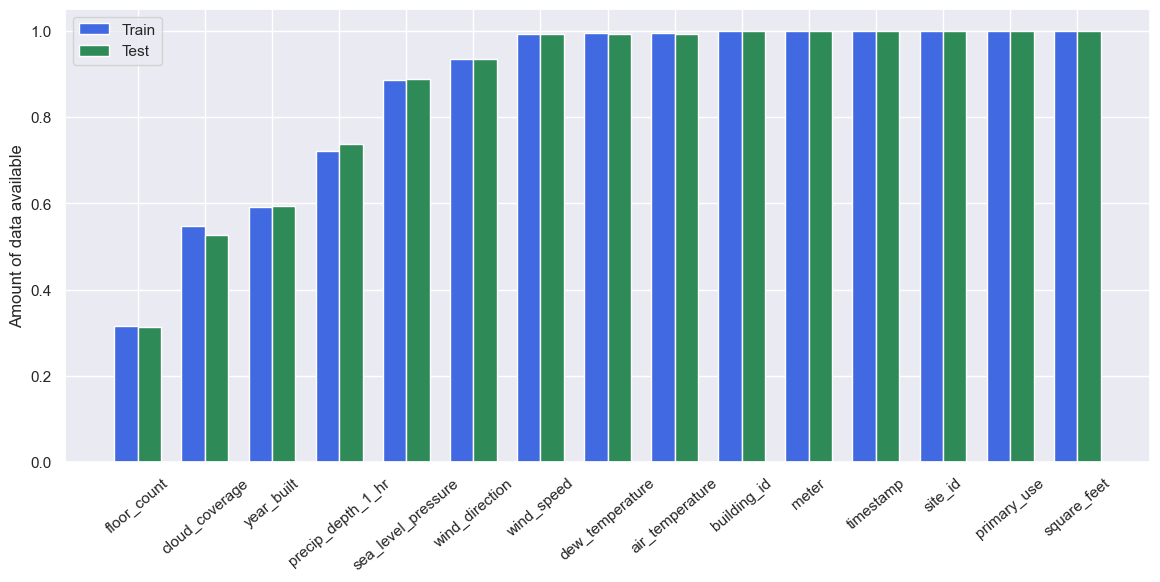

In [34]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

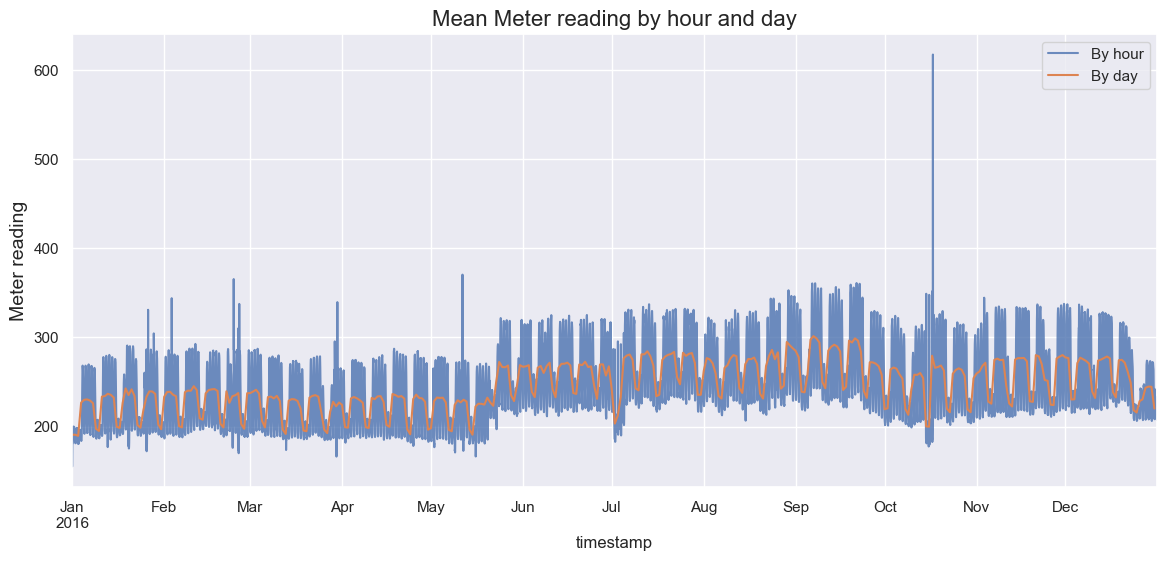

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();